In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
%matplotlib inline

## Домашнее задание: 

разобрать презентацию по деревьям:   https://amueller.github.io/COMS4995-s20/slides/aml-07-trees-forests/#45
видео: http://www.cs.columbia.edu/~amueller/comsw4995s20/schedule/

Сделать свой короткий тьюториал с разбором конкретного датасета, либо своего, либо для данных по раку

In [3]:
#загружаем датасет

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

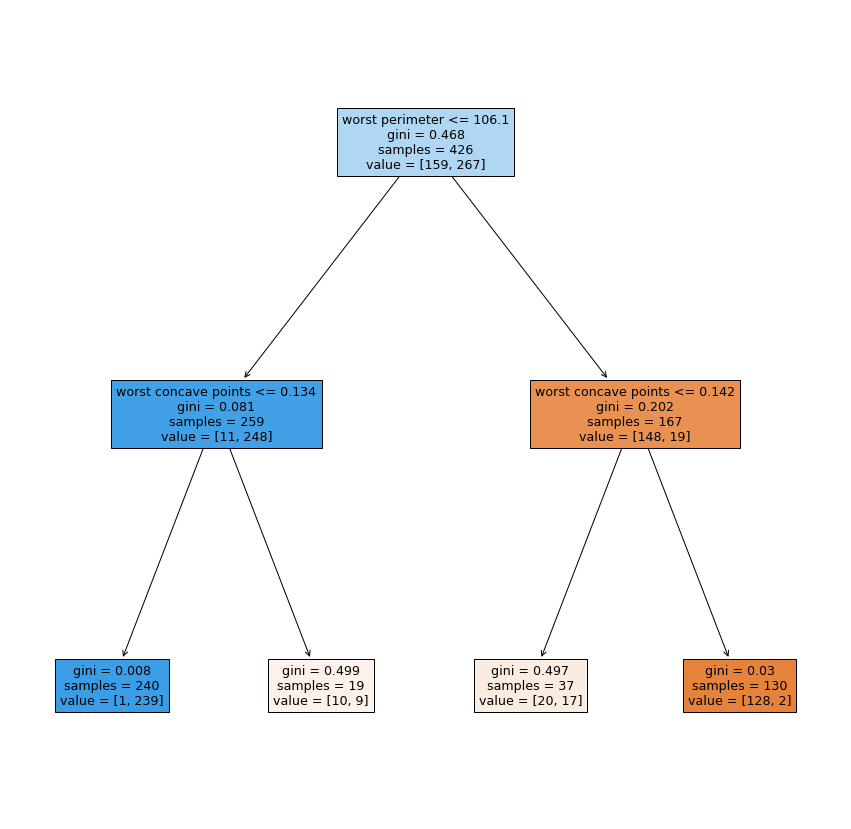

In [4]:
#теперь делим наши данные на тренировочную и тестовую выборку, строим нашу модель и применяем к ней данные

#stratify - это стратификация наших данных, чтобы в каждой "ячейке" было одинаковое количество сэмплов каждого класса 
#подробнее про stratify можно прочитать здесь: https://scikit-learn.org/stable/modules/cross_validation.html#stratification

#random_state стоит нулевой, так как нам не нужно рандомизировать наши данные при делении

#max_depth - это глубина ветвления нашего дерева 

#изначально график дерева был слишком маленький и чёрно-белый, с помощью filled мы сделали его цветным, а с figure - большим

fig = plt.figure(figsize=(15,15))
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)
tree_dot = plot_tree(tree, feature_names=cancer.feature_names, filled=True)

In [5]:
#коэффициенты получились не самые удачные, надо попробовать подобрать гиперпараметры получше
#сейчас мы будем смотреть изменения наших score при изменении параметров

#чтобы узнать результаты наших изысканий нужно посмотреть идеальный параметр и что мы получили 
#в качестве score при таком параметре 
#мы выставляем return_train_score для того чтобы дальше строить наглядные графики

param_grid = {
    'max_depth':range(1,7),
    'max_leaf_nodes':range(2, 20),
    'ccp_alpha': np.linspace(0.,0.03, 20)
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=10, return_train_score=True)
grid.fit(X_train, y_train)
display(grid.best_params_)
display(grid.best_score_)

0.9271317829457365

In [6]:
#в презентации есть график score при том или ином параметре, самого кода такого графика нет, но я нашла похожий на 
#стэк оверфлоу: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

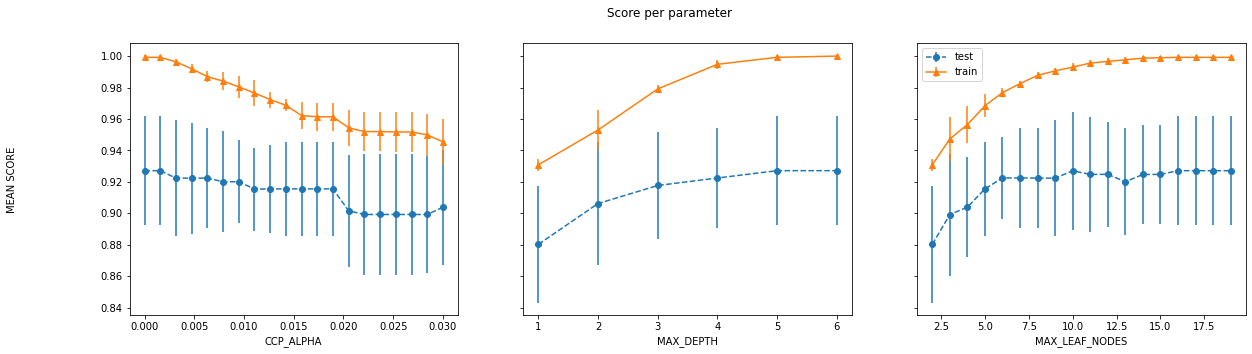

In [7]:
plot_search_results(grid)

In [8]:
#теперь давайте разберёмся какие параметры мы вообще считали 
#ccp_alpha - это коэффициент, который рассчитывает Cost Complexity Puring 
#max_depth - уже разбирали 
#max_leaf_nodes - это nodes are defined as relative reduction in impurity

/opt/python/envs/default/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


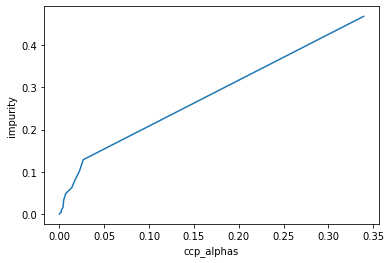

In [9]:
#мы также можем посмотреть на графике то как вычислялся наш ccp 

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurity = path.ccp_alphas, path.impurities

ax = sns.lineplot(ccp_alphas, impurity)
ax.set_xlabel('ccp_alphas')
ax.set_ylabel('impurity')

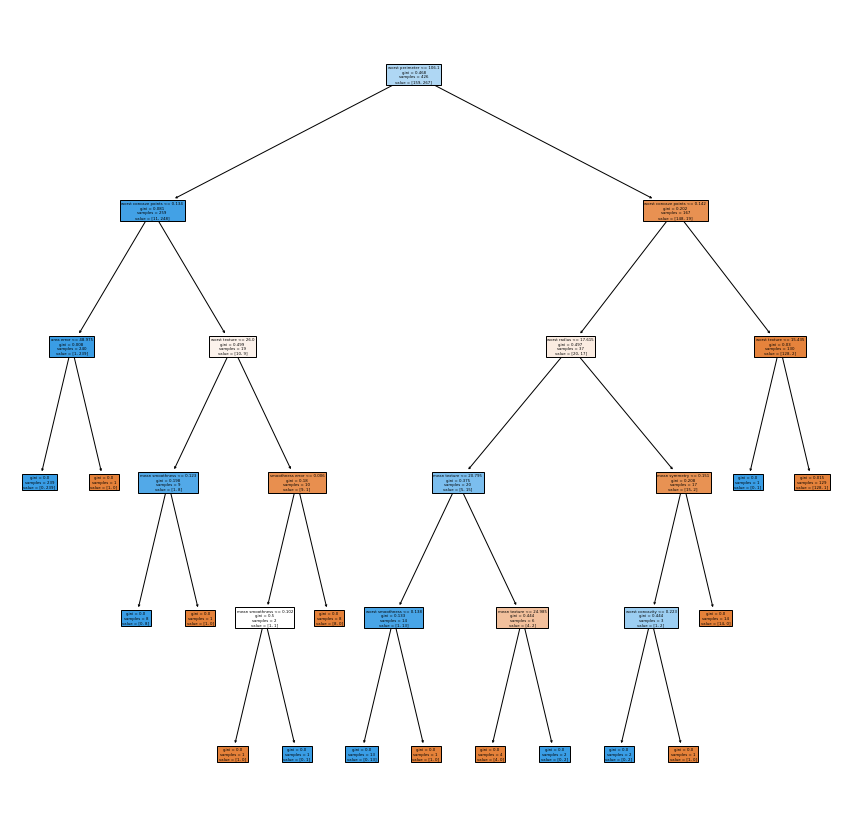

In [10]:
#теперь посмотрим как выглядит наше дерево с наилучшими параметрами 
fig = plt.figure(figsize=(15,15))

tree = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=16, ccp_alpha=0.0)
tree.fit(X_train, y_train)
tree_dot = plot_tree(tree, feature_names=cancer.feature_names, filled=True)

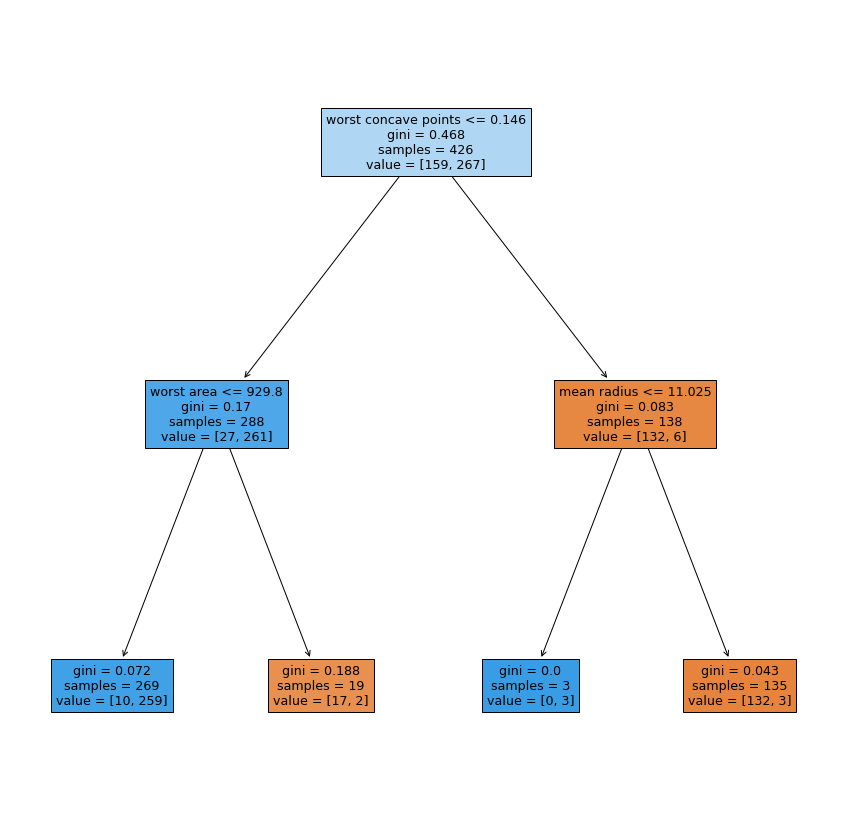

In [11]:
#в чём проблема деревьев? они нестабильны, посмотрим это на нашем изначальном дереве (оно короче, будет виднее)
#единственное, что мы сделаем - это слегка рандомизируем данные и увидим, что деревья совсем не похожи друг на друга

fig = plt.figure(figsize=(15,15))
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=1)
tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train, y_train)
tree_dot = plot_tree(tree, feature_names=cancer.feature_names, filled=True)

In [12]:
#да и вообще у таких моделей очень много недостатков и сами по себе они редко используются, они используются в композиционных
#алгоритмах, в общем, если много голов принимает решение, оно уже более менее объективное, всё как у людей

#один из таких алгоритмов это Voting Classifier 
#об этой модели поподробнее
#что значит мягкое и тёплое голосование

voting = VotingClassifier(
    [('logreg', LogisticRegression(C=100)),
     ('tree', DecisionTreeClassifier(max_depth=3, random_state=0))], voting='soft'
)

voting.fit(X_train, y_train)
logreg, tree = voting.estimators_

#теперь сравнимы скоры каждой модельки по отдельности и их ансамбля 
display(tree.score(X_test, y_test))
display(logreg.score(X_test, y_test))
display(voting.score(X_test, y_test))

#вместе модельки работают лучше 

#а тепеоь будем визуализировать то, что у нас получилось 
#кода для визуализации в презентации не было, решение я нашла в
#https://towardsdatascience.com/solving-a-simple-classification-problem-with-python-fruits-lovers-edition-d20ab6b071d2


/opt/python/envs/default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.951048951048951

In [13]:
pred = tree.predict(X_test)
roc_auc_score(y_test, pred)

0.9400419287211741

In [30]:
#есть ещё и другие алгоритмы - бэггинг, случайный лес 
#вот со случайным лесом мы сейчас и разберёмся 

#что такое warm start #что такое estimator range

train_scores = []
test_scores = []

rf = RandomForestClassifier(warm_start=True)
estimator_range = range(1,100,5)
for n_estimator in estimator_range: 
    rf.n_estimators = n_estimator
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))

In [31]:
print(train_scores)
print(test_scores)

[0.9647887323943662, 0.9953051643192489, 0.9929577464788732, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9020979020979021, 0.9440559440559441, 0.9370629370629371, 0.9300699300699301, 0.9300699300699301, 0.9300699300699301, 0.9370629370629371, 0.9300699300699301, 0.9440559440559441, 0.9440559440559441, 0.9440559440559441, 0.9440559440559441, 0.9440559440559441, 0.9440559440559441, 0.9440559440559441, 0.9440559440559441, 0.9440559440559441, 0.9440559440559441, 0.951048951048951, 0.951048951048951]


In [32]:
#можно также настроить out of bag score 
train_scores = []
test_scores = []
oob_scores = []
feature_range = range(1, X_train.shape[1], 5)
for max_features in feature_range:
    rf = RandomForestClassifier(max_features=max_features, oob_score=True,
                                n_estimators=64, random_state=0)
    rf.fit(X_train, y_train)
    train_scores.append(rf.score(X_train, y_train))
    test_scores.append(rf.score(X_test, y_test))
    oob_scores.append(rf.oob_score_)
    

In [33]:
print(train_scores)
print(test_scores)
print(oob_scores)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9440559440559441, 0.951048951048951, 0.951048951048951, 0.951048951048951, 0.951048951048951, 0.951048951048951]
[0.9577464788732394, 0.9671361502347418, 0.9694835680751174, 0.9530516431924883, 0.960093896713615, 0.9647887323943662]
